In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import players
player_names = list(map(str, players.players))
number_of_digits = 3  # Number of digits to round for LaTeX tables

turns = 200
number_of_players = len(player_names)

assert number_of_players == 176

def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    string = string.replace("1_1_1", "1\_1\_1")
    return string

# Study the standard tournaments

## Scores

In [33]:
def read_scores(files):
    dfs = []
    for gz in files:
        if "scores" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    df /= turns * (number_of_players - 1)  # Scale all scores
    return df

In [34]:
standard_files = glob.glob("./data/*_0_1000*gz")
scores = read_scores(files=standard_files)

In [35]:
with open("../assets/standard_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [36]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    return df

score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
EvolvedLookerUp2_2_2     2.954937  0.010394  2.915457  2.936941  2.948000   
Evolved HMM 5            2.954333  0.013890  2.903257  2.931284  2.944707   
Evolved FSM 16           2.952436  0.013192  2.900371  2.929656  2.943543   
PSO Gambler 2_2_2        2.938380  0.013361  2.885514  2.913314  2.929857   
Evolved FSM 16 Noise 05  2.918978  0.012610  2.874286  2.898083  2.910429   
PSO Gambler 1_1_1        2.911675  0.023403  2.809600  2.872971  2.895943   
Evolved ANN 5            2.911783  0.010177  2.872743  2.894400  2.904829   
Evolved FSM 4            2.909684  0.012060  2.868343  2.889314  2.901229   
Evolved ANN              2.907322  0.010036  2.865457  2.890600  2.900514   
PSO Gambler Mem1         2.901336  0.025270  2.794314  2.858741  2.884343   
Evolved ANN 5 Noise 05   2.864188  0.008217  2.837171  2.850286  2.858429   
DBS: 0.75, 3, 4, 3, 5    2.857175  0.008885  2.826629  2.842457  2.850914   
Winner12                 2.849259  0.008071  2.821400  2.835600  2.843429   
Fool Me Once             2.843997  0.008189  2.819686  2.830541  2.838029   
Omega TFT: 3, 8          2.840844  0.011254  2.804800  2.822257  2.833000   

                              50%       75%       95%       max  
EvolvedLookerUp2_2_2     2.955514  2.962571  2.970943  2.984286  
Evolved HMM 5            2.954357  2.964057  2.976829  3.002743  
Evolved FSM 16           2.953086  2.961943  2.973057  2.993171  
PSO Gambler 2_2_2        2.940257  2.948400  2.957200  2.971343  
Evolved FSM 16 Noise 05  2.919014  2.927600  2.939629  2.960943  
PSO Gambler 1_1_1        2.912086  2.927457  2.950057  3.011857  
Evolved ANN 5            2.912057  2.919314  2.927771  2.944114  
Evolved FSM 4            2.910229  2.918521  2.928516  2.941857  
Evolved ANN              2.907543  2.914486  2.923457  2.941629  
PSO Gambler Mem1         2.901771  2.918771  2.942314  2.983543  
Evolved ANN 5 Noise 05   2.864543  2.870343  2.876971  2.890743  
DBS: 0.75, 3, 4, 3, 5    2.857257  2.863400  2.871829  2.888314  
Winner12                 2.849629  2.855257  2.861914  2.872800  
Fool Me Once             2.844286  2.849714  2.857229  2.881943  
Omega TFT: 3, 8          2.840943  2.848657  2.859257  2.878029

In [37]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

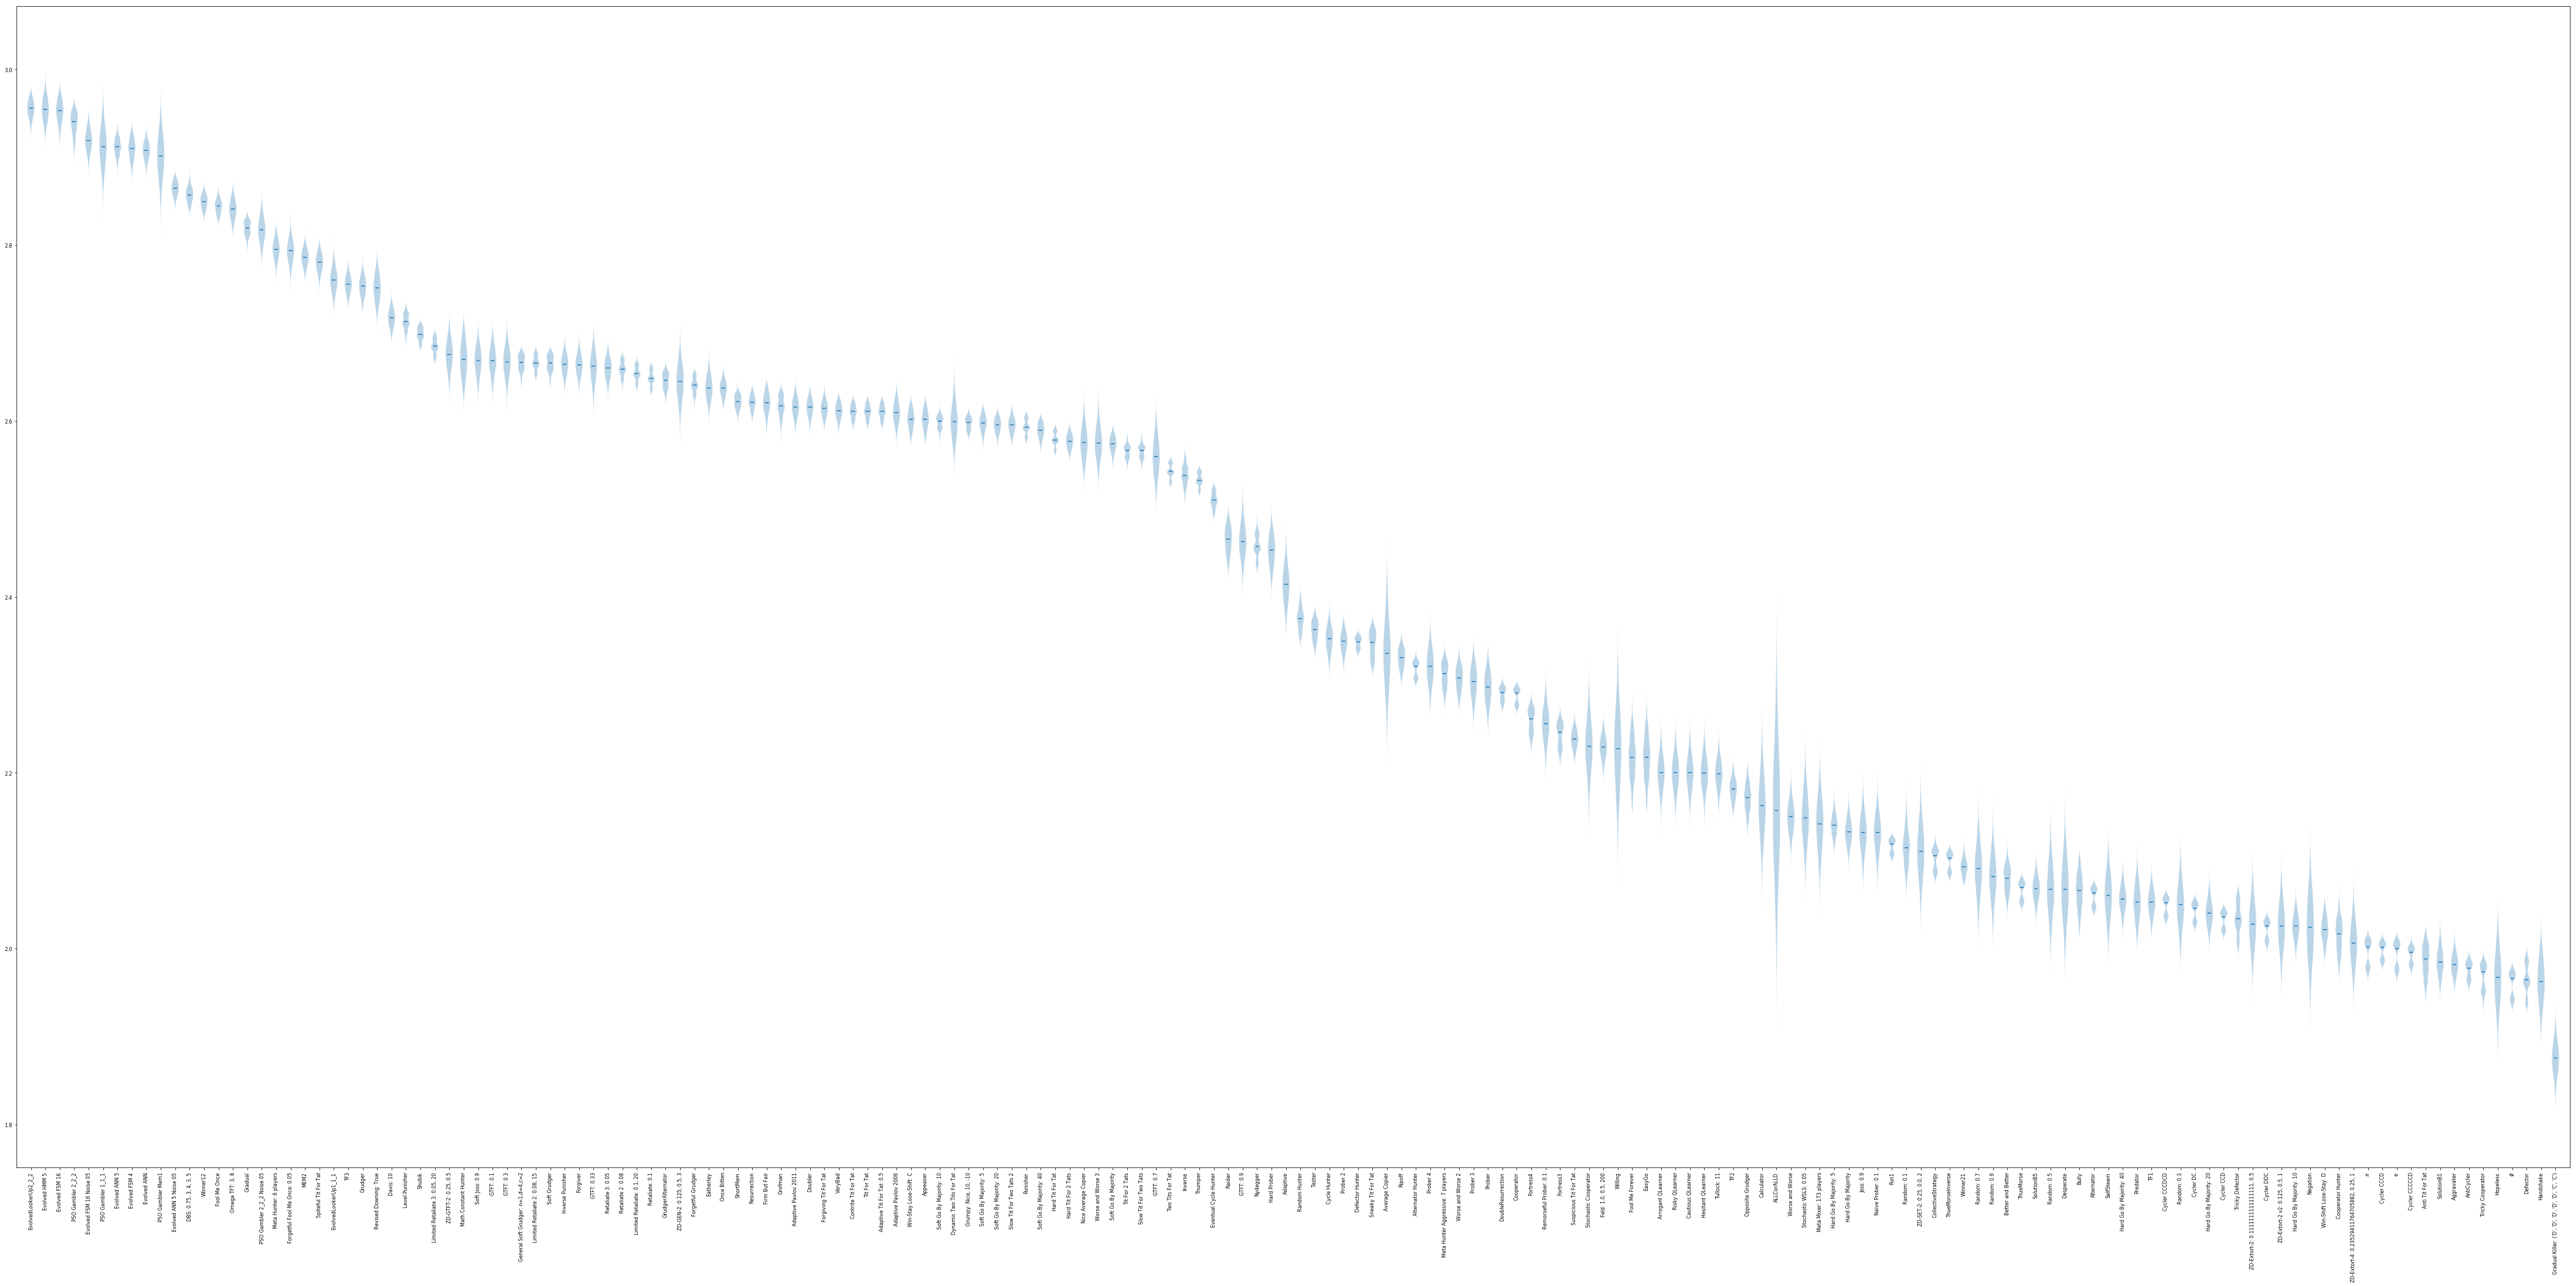

In [38]:
def violon_plot(scores, summary, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 3
    height = width / 2 
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='both', which='both', labelsize=8)
    fig.tight_layout()
    fig.savefig(filename);
    
violon_plot(scores, score_summary, "../assets/standard_scores_boxplots.pdf")

## Ranks

Every row corresponds to a tournament. We can see the ranks of each strategy across the tournament repetitions.

In [40]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df

rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2      2.180700  1.067914    1   1.0   1.0   2.0   3.0   
Evolved HMM 5             2.323400  1.271739    1   1.0   1.0   2.0   3.0   
Evolved FSM 16            2.472500  1.296690    1   1.0   1.0   2.0   3.0   
PSO Gambler 2_2_2         3.969100  1.538176    1   2.0   3.0   4.0   5.0   
Evolved FSM 16 Noise 05   6.301300  1.698301    1   4.0   5.0   6.0   7.0   
PSO Gambler 1_1_1         7.117900  2.502006    1   3.0   5.0   7.0   9.0   
Evolved ANN 5             7.278200  1.524793    2   5.0   6.0   7.0   8.0   
Evolved FSM 4             7.521033  1.628399    2   5.0   6.0   8.0   9.0   
Evolved ANN               7.890367  1.464652    2   5.0   7.0   8.0   9.0   
PSO Gambler Mem1          8.209800  2.525802    1   4.0   6.0   9.0  10.0   
Evolved ANN 5 Noise 05   11.360000  0.873356    9  10.0  11.0  11.0  12.0   
DBS: 0.75, 3, 4, 3, 5    12.182133  1.106018    9  11.0  11.0  12.0  13.0   
Winner12                 13.234600  1.139481    9  11.0  12.0  13.0  14.0   
Fool Me Once             13.959600  1.085747    9  12.0  13.0  14.0  15.0   
Omega TFT: 3, 8          14.281467  1.294303   10  12.0  13.0  15.0  15.0   

                          95%  max  
EvolvedLookerUp2_2_2      4.0    7  
Evolved HMM 5             5.0    9  
Evolved FSM 16            5.0    9  
PSO Gambler 2_2_2         7.0   10  
Evolved FSM 16 Noise 05   9.0   11  
PSO Gambler 1_1_1        10.0   16  
Evolved ANN 5            10.0   11  
Evolved FSM 4            10.0   12  
Evolved ANN              10.0   12  
PSO Gambler Mem1         12.0   18  
Evolved ANN 5 Noise 05   13.0   16  
DBS: 0.75, 3, 4, 3, 5    14.0   16  
Winner12                 15.0   17  
Fool Me Once             15.0   17  
Omega TFT: 3, 8          16.0   19

In [41]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

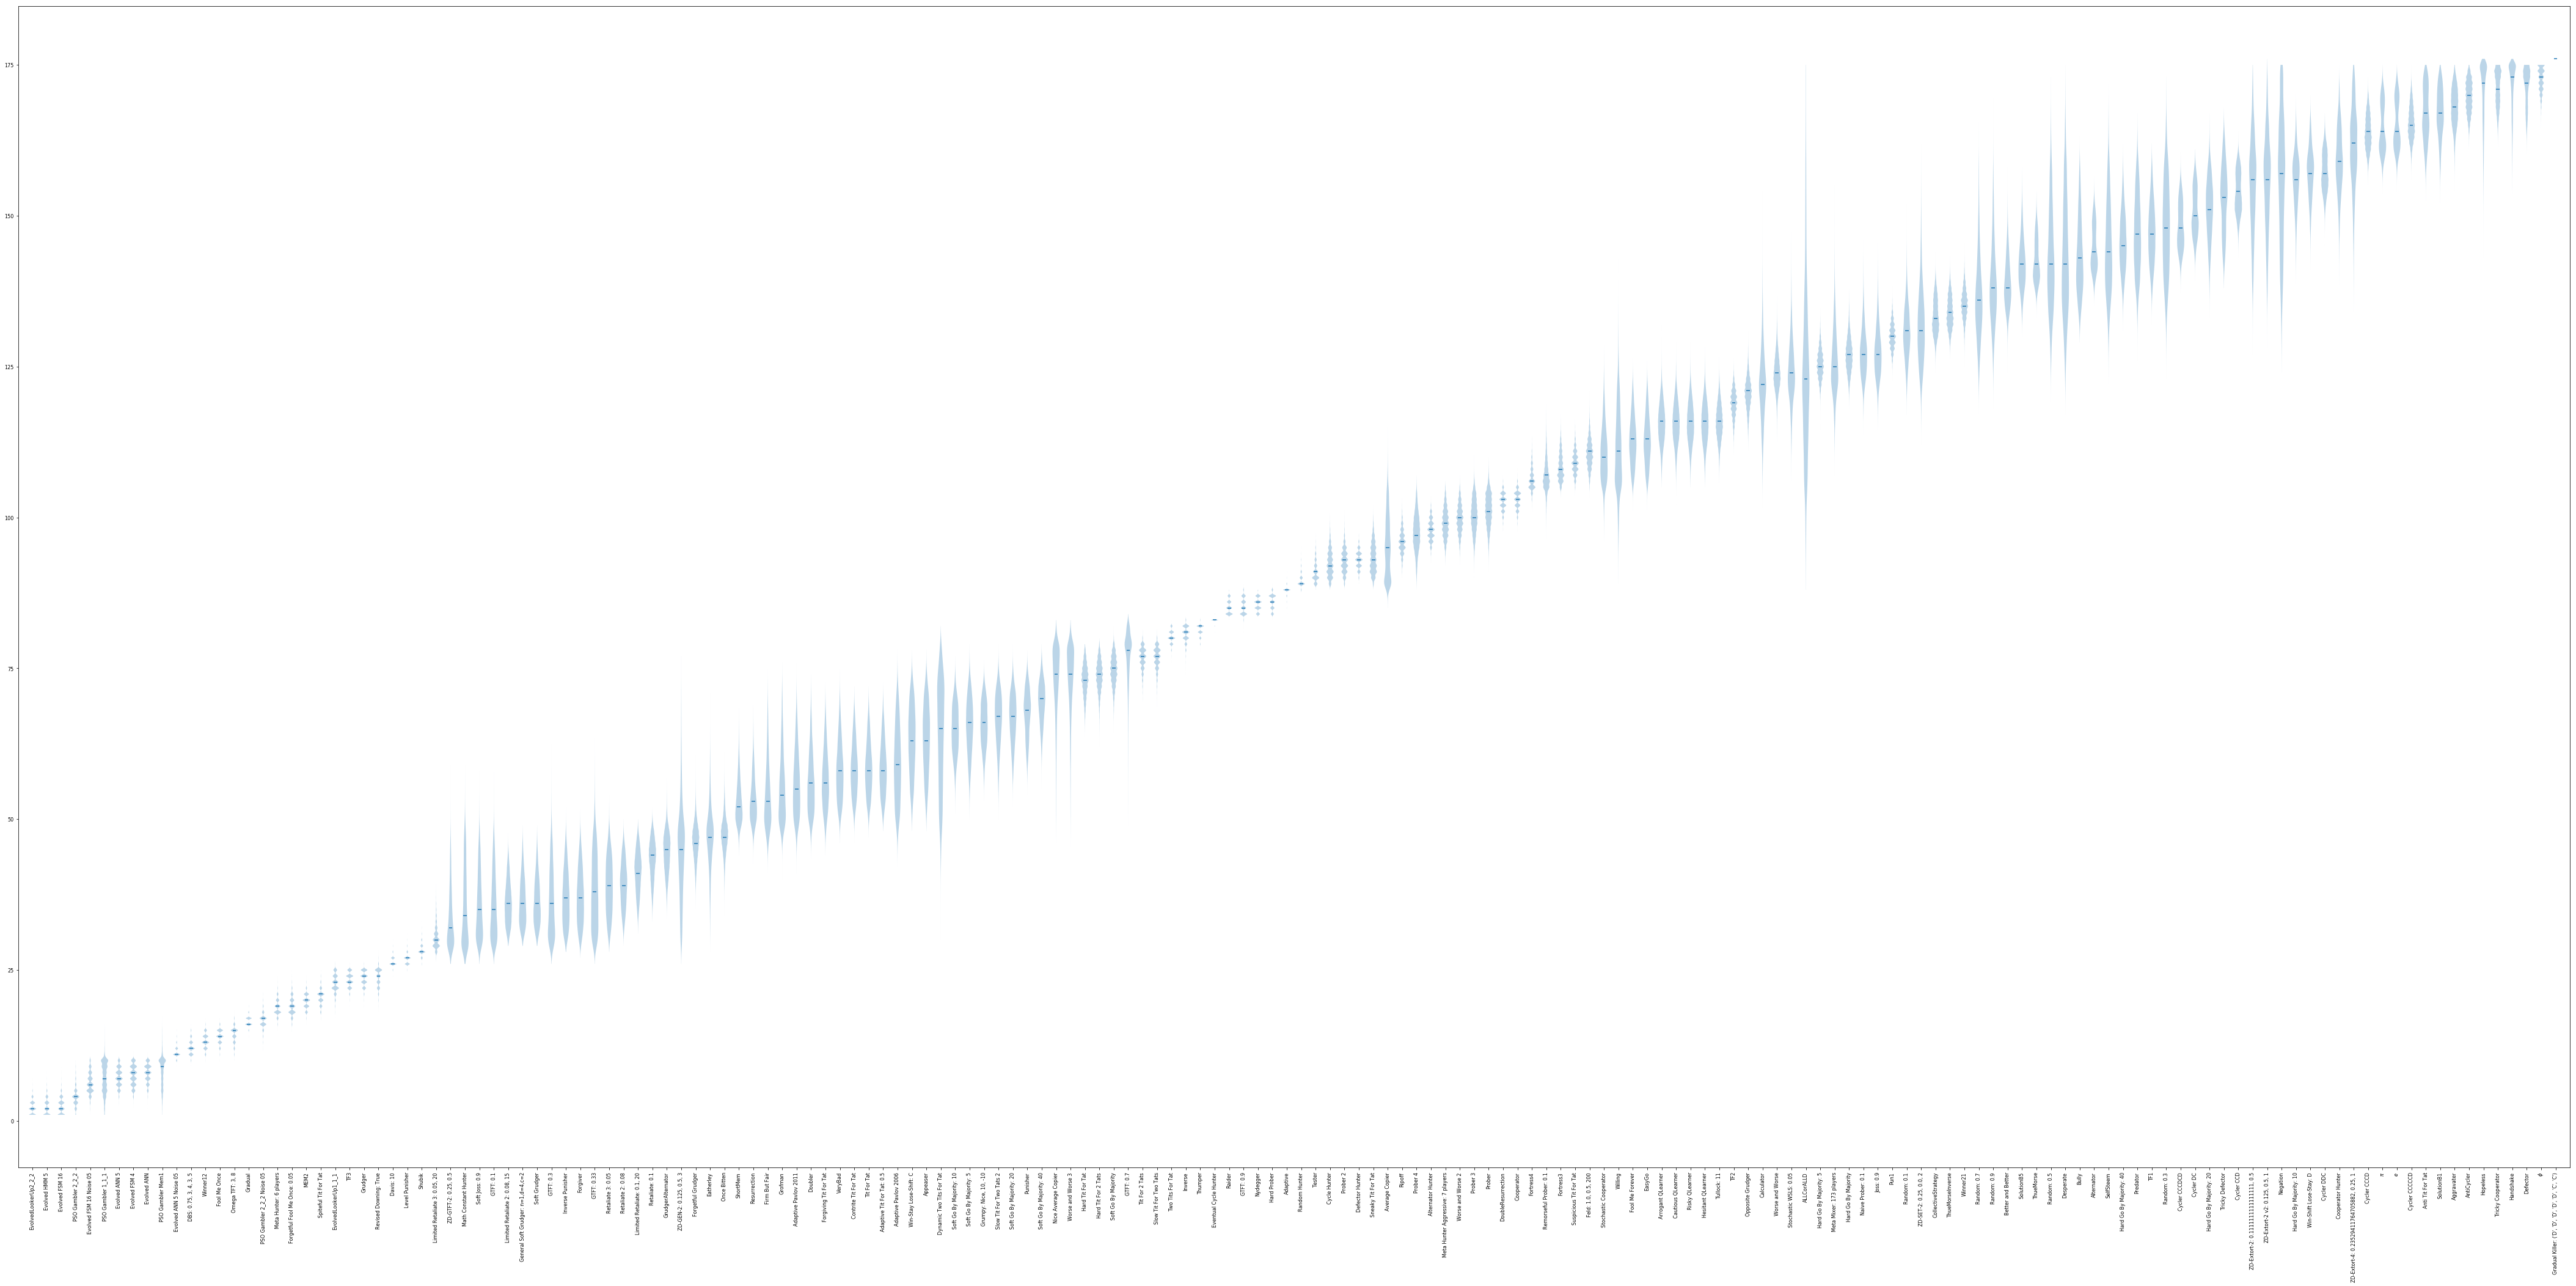

In [42]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/standard_ranks_boxplots.pdf")

## Payoff matrix

As all the individual payoff matrix files have the mean values and they all have the same number of repetitions, the mean of the means is the mean over all tournaments.

In [43]:
def read_payoff_matrix(files):
    arrays = []
    for gz in files:
        if "payoff_matrix" in gz:
            arrays.append(np.array(pd.read_csv(gz, header=None)))  # Read through pd to deal with float conversion
    return sum(arrays) / len(arrays)

In [44]:
payoff_matrix = read_payoff_matrix(files=standard_files)
assert payoff_matrix.shape == (176, 176)

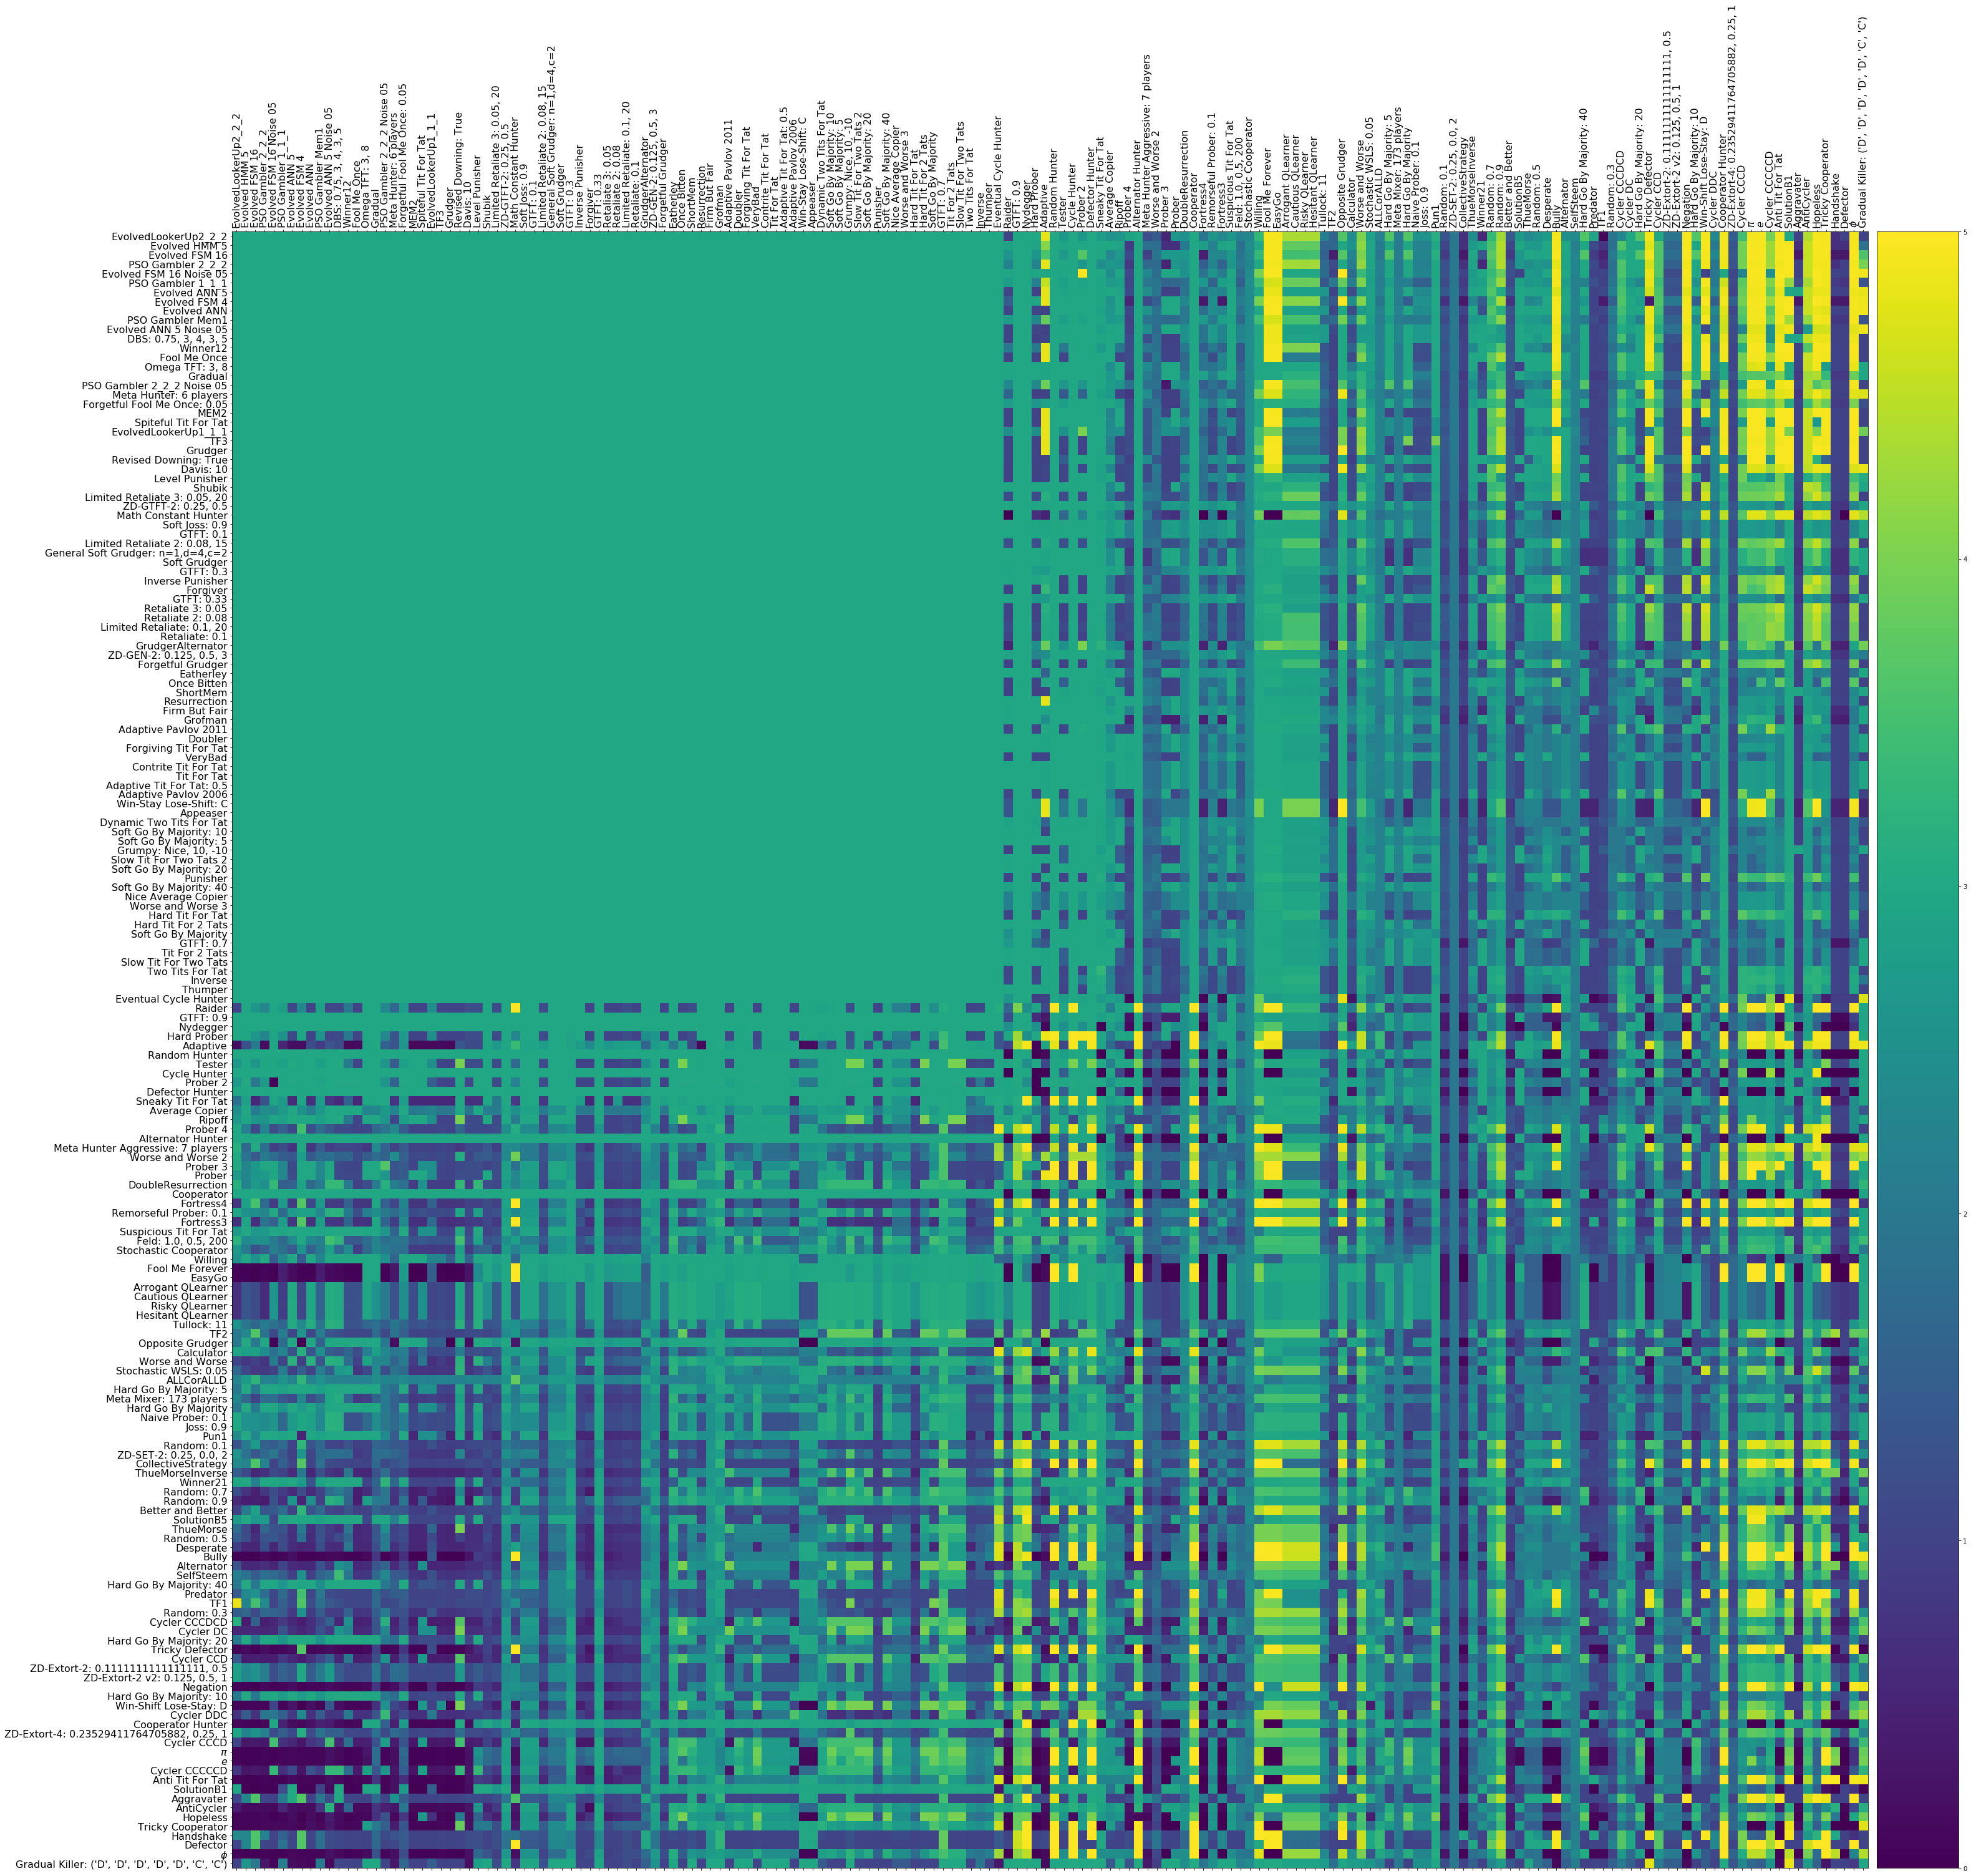

In [45]:
def payoff_heatmap(matrix, ranked_player_names, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(ranked_player_names, rotation=90)
    ax.set_yticklabels(ranked_player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);
    
ranked_player_names = list(rank_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]
payoff_heatmap(ranked_payoff_matrix, ranked_player_names, "../assets/standard_scores_heatmap.pdf")

## Head to head wins

In [46]:
def read_wins(files):
    dfs = []
    for gz in files:
        if "wins" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    return df

In [47]:
wins = read_wins(files=standard_files)

In [48]:
def summarise_wins(wins, score_summary):
    df = wins.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df.loc[score_summary.index]

win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2     48.261667  1.335159   43  46.0  47.0  48.0  49.0   
Evolved HMM 5            41.348933  1.225104   37  39.0  41.0  41.0  42.0   
Evolved FSM 16           56.973133  1.102222   51  55.0  56.0  57.0  58.0   
PSO Gambler 2_2_2        40.677067  1.085384   36  39.0  40.0  41.0  41.0   
Evolved FSM 16 Noise 05  40.074600  1.677346   34  37.0  39.0  40.0  41.0   
PSO Gambler 1_1_1        44.979667  1.597443   39  42.0  44.0  45.0  46.0   
Evolved ANN 5            43.221667  0.673519   41  42.0  43.0  43.0  44.0   
Evolved FSM 4            37.230333  0.951003   35  36.0  37.0  37.0  38.0   
Evolved ANN              43.107800  1.021428   40  42.0  42.0  43.0  44.0   
PSO Gambler Mem1         43.465600  1.831276   37  40.0  42.0  44.0  45.0   
Evolved ANN 5 Noise 05   33.706933  1.122644   30  32.0  33.0  34.0  34.0   
DBS: 0.75, 3, 4, 3, 5    32.328133  1.200010   28  30.0  32.0  32.0  33.0   
Winner12                 40.175200  1.041110   37  39.0  39.0  40.0  41.0   
Fool Me Once             50.122533  0.422292   49  50.0  50.0  50.0  50.0   
Omega TFT: 3, 8          35.157733  0.859517   33  34.0  35.0  35.0  36.0   

                          95%  max  
EvolvedLookerUp2_2_2     50.0   53  
Evolved HMM 5            43.0   45  
Evolved FSM 16           59.0   60  
PSO Gambler 2_2_2        42.0   44  
Evolved FSM 16 Noise 05  43.0   47  
PSO Gambler 1_1_1        48.0   51  
Evolved ANN 5            44.0   47  
Evolved FSM 4            39.0   41  
Evolved ANN              45.0   48  
PSO Gambler Mem1         46.0   49  
Evolved ANN 5 Noise 05   35.0   38  
DBS: 0.75, 3, 4, 3, 5    34.0   37  
Winner12                 42.0   44  
Fool Me Once             51.0   52  
Omega TFT: 3, 8          37.0   39

In [49]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

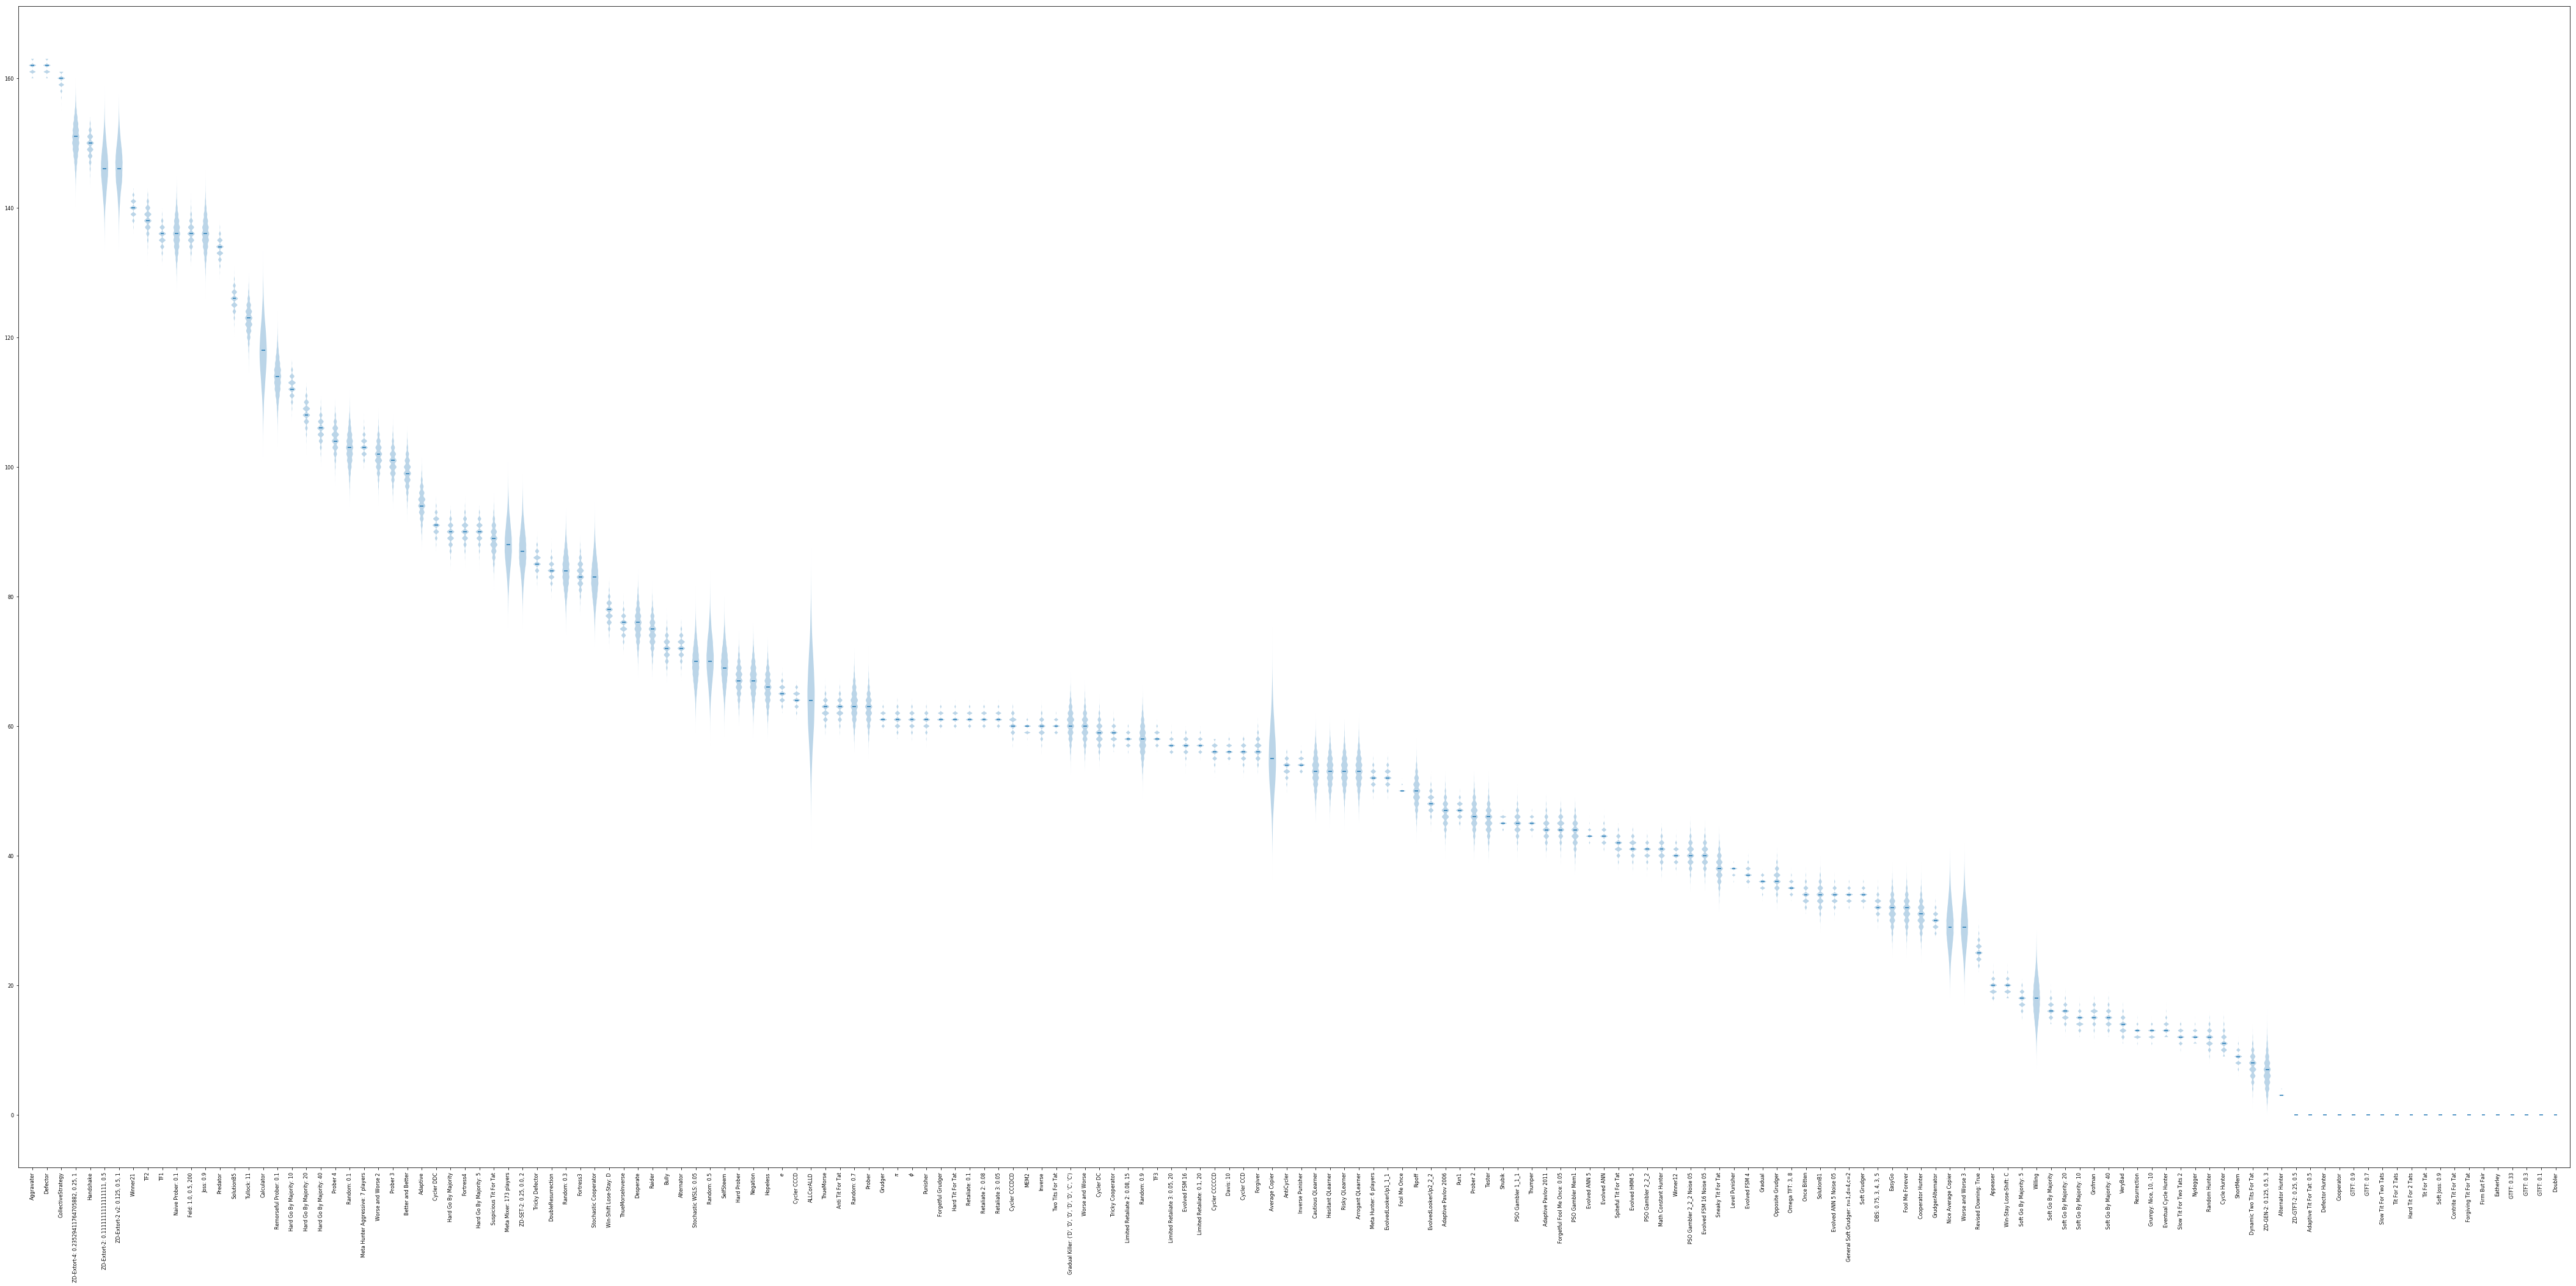

In [50]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/standard_wins_boxplots.pdf")

# Study the noisy tournaments


## Scores

In [51]:
noisy_files = glob.glob("./data/*_5_1000*gz")
scores = read_scores(files=noisy_files)

In [52]:
with open("../assets/noisy_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [53]:
score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
DBS: 0.75, 3, 4, 3, 5       2.572830  0.024499  2.483114  2.533284  2.556250   
Evolved ANN 5 Noise 05      2.533738  0.025207  2.417857  2.491657  2.517221   
Evolved FSM 16 Noise 05     2.514985  0.030976  2.374400  2.463970  2.494029   
Evolved ANN 5               2.409251  0.030329  2.296714  2.359141  2.388914   
Evolved FSM 4               2.392650  0.027114  2.286343  2.348656  2.374086   
Evolved HMM 5               2.391694  0.026124  2.290886  2.348771  2.373914   
Level Punisher              2.388635  0.025064  2.290229  2.347429  2.371771   
Omega TFT: 3, 8             2.386708  0.026138  2.269514  2.343400  2.369257   
Spiteful Tit For Tat        2.382871  0.029577  2.259200  2.334427  2.362886   
Evolved FSM 16              2.374908  0.029446  2.256343  2.326027  2.355257   
PSO Gambler 2_2_2 Noise 05  2.370868  0.028624  2.257829  2.324199  2.351886   
Adaptive                    2.369045  0.037981  2.217486  2.307029  2.343507   
Evolved ANN                 2.365432  0.021950  2.279514  2.329457  2.350743   
Math Constant Hunter        2.344313  0.022594  2.263143  2.307541  2.328914   
Gradual                     2.340790  0.021206  2.247943  2.305599  2.326486   

                                 50%       75%       95%       max  
DBS: 0.75, 3, 4, 3, 5       2.572900  2.589057  2.613316  2.667343  
Evolved ANN 5 Noise 05      2.534286  2.550886  2.574860  2.629000  
Evolved FSM 16 Noise 05     2.515057  2.536057  2.565857  2.642143  
Evolved ANN 5               2.409286  2.429800  2.458600  2.535771  
Evolved FSM 4               2.392571  2.410950  2.437457  2.492943  
Evolved HMM 5               2.391886  2.409286  2.434859  2.492200  
Level Punisher              2.388771  2.405571  2.429143  2.487286  
Omega TFT: 3, 8             2.387086  2.404314  2.428630  2.489686  
Spiteful Tit For Tat        2.383057  2.402743  2.431601  2.487714  
Evolved FSM 16              2.375171  2.394971  2.422859  2.494343  
PSO Gambler 2_2_2 Noise 05  2.370914  2.390086  2.417374  2.477343  
Adaptive                    2.368857  2.394486  2.432003  2.510114  
Evolved ANN                 2.365286  2.380207  2.401371  2.482857  
Math Constant Hunter        2.344171  2.359429  2.382000  2.430971  
Gradual                     2.341029  2.355121  2.375257  2.429371

In [54]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

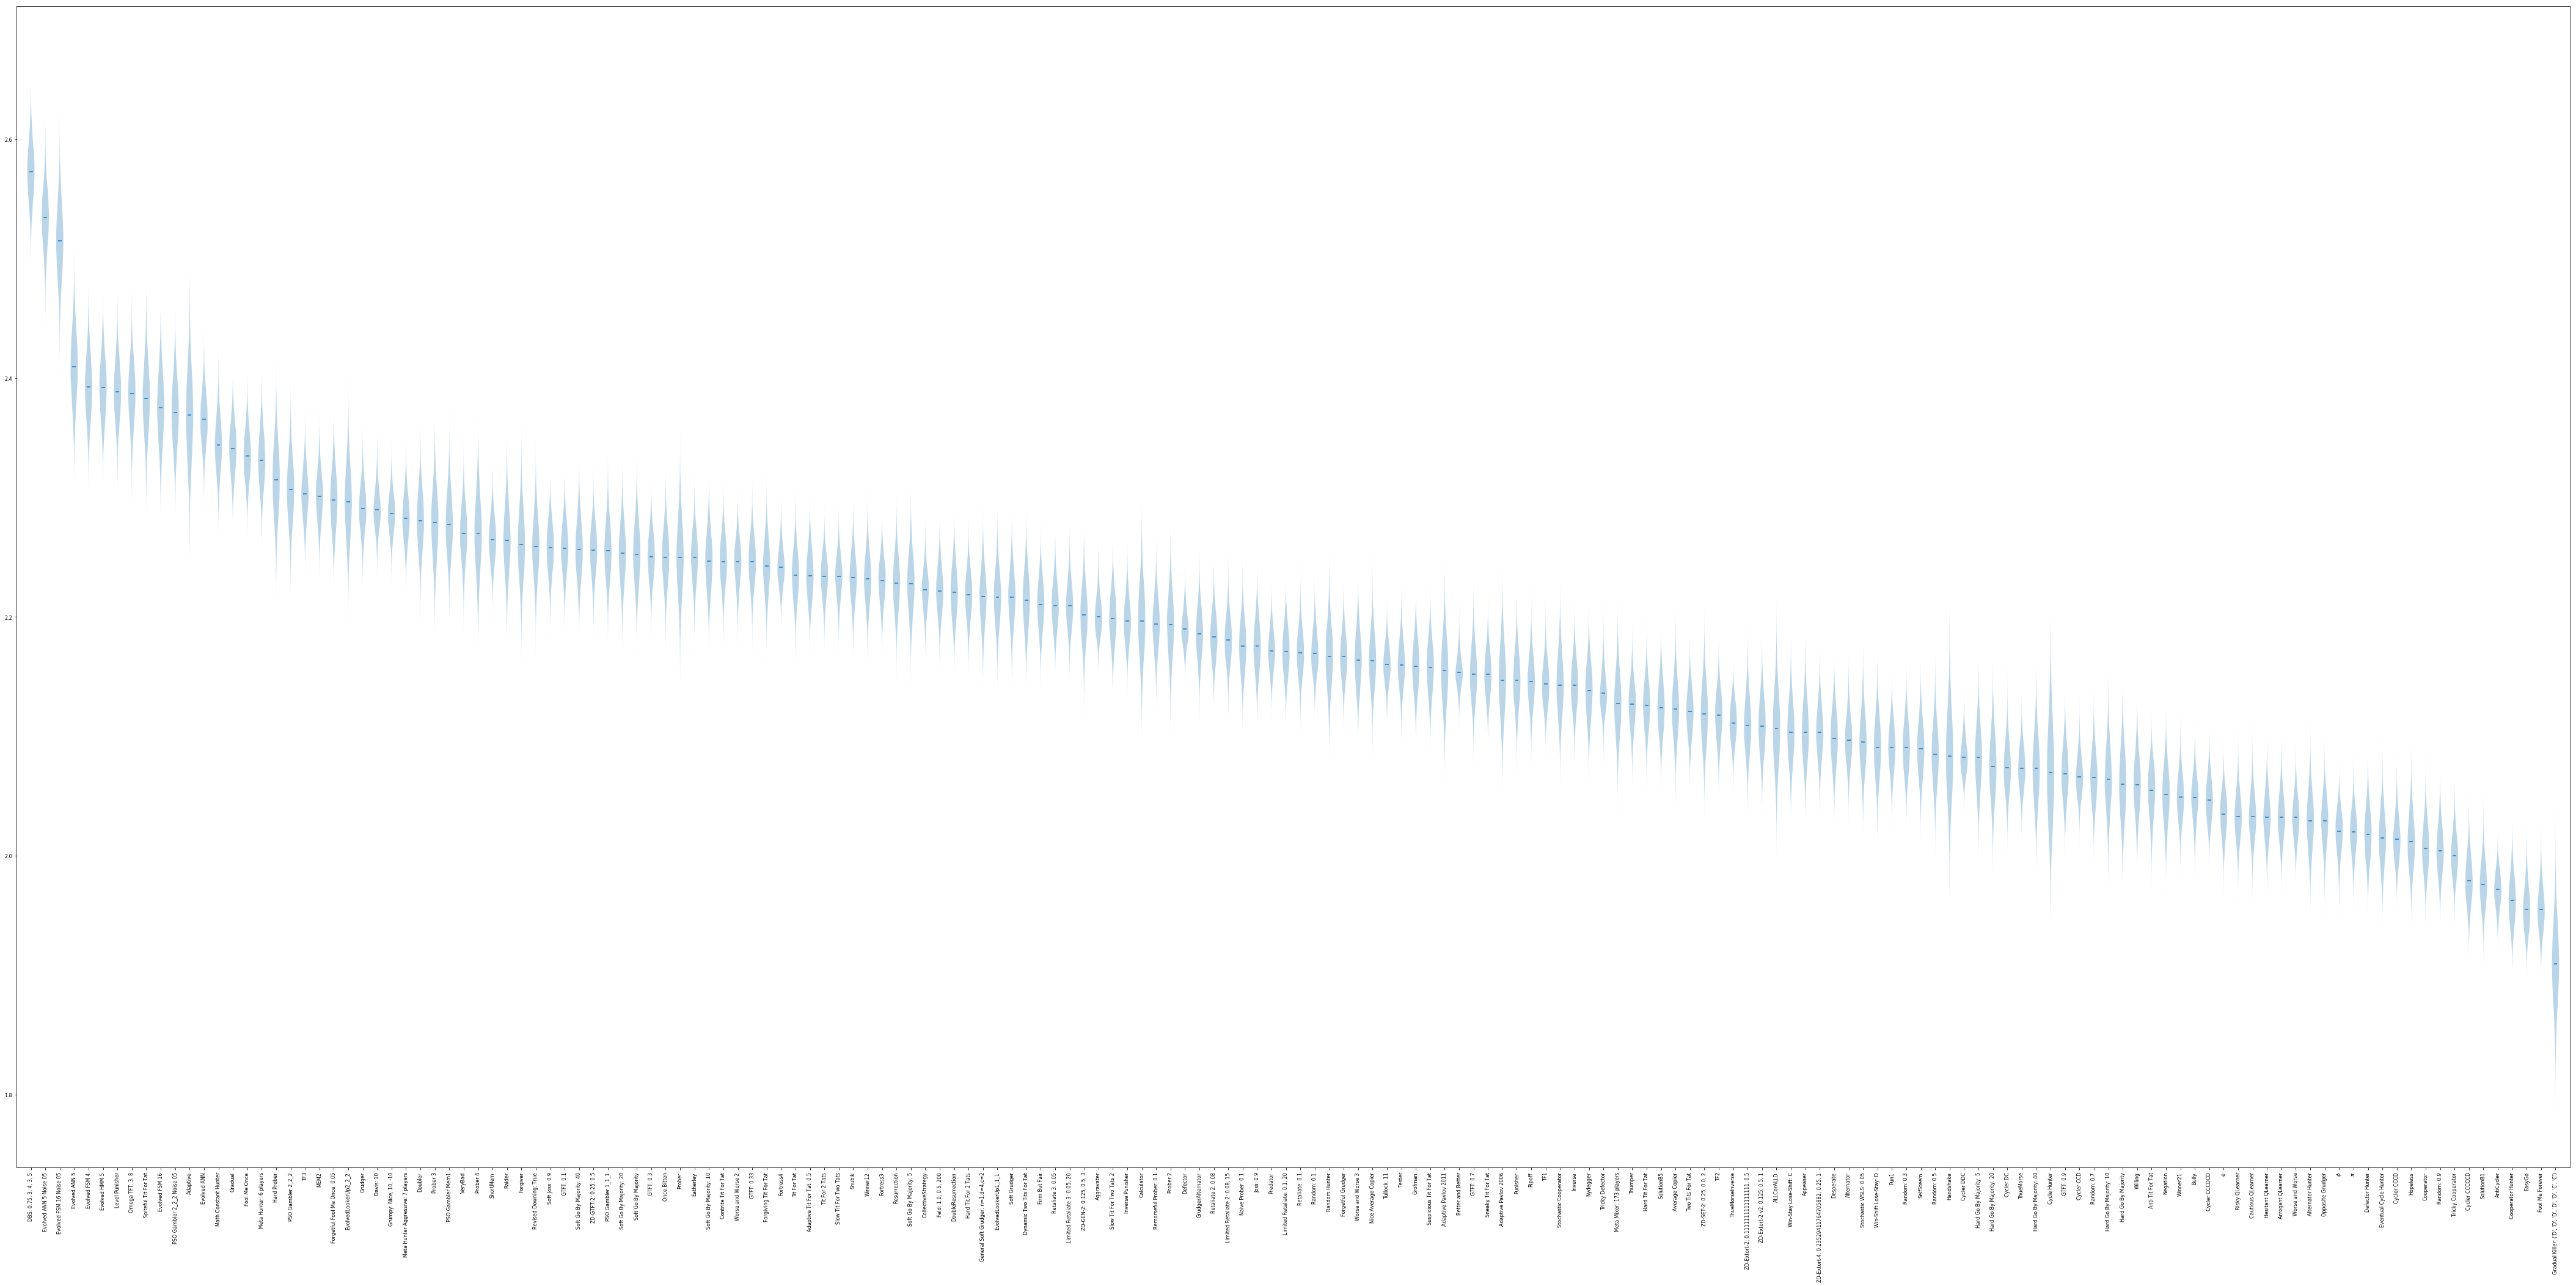

In [55]:
violon_plot(scores, score_summary, "../assets/noisy_scores_boxplots.pdf")

## Ranks

In [56]:
rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
DBS: 0.75, 3, 4, 3, 5        1.207733  0.471340    1   1.0   1.0   1.0   1.0   
Evolved ANN 5 Noise 05       2.186167  0.627921    1   1.0   2.0   2.0   3.0   
Evolved FSM 16 Noise 05      2.621200  0.624796    1   1.0   2.0   3.0   3.0   
Evolved ANN 5                6.379500  2.791836    2   4.0   4.0   5.0   8.0   
Evolved FSM 4                7.920167  3.186208    3   4.0   5.0   7.0  10.0   
Evolved HMM 5                7.987067  3.111256    3   4.0   5.5   7.0  10.0   
Level Punisher               8.298633  3.093543    3   4.0   6.0   8.0  10.0   
Omega TFT: 3, 8              8.562300  3.279622    3   4.0   6.0   8.0  11.0   
Spiteful Tit For Tat         9.184967  3.781705    3   4.0   6.0   9.0  12.0   
Evolved FSM 16              10.210300  4.092966    3   4.0   7.0  10.0  13.0   
PSO Gambler 2_2_2 Noise 05  10.738867  4.072200    3   5.0   8.0  10.0  13.0   
Evolved ANN                 11.335067  3.243984    3   6.0   9.0  11.0  13.0   
Adaptive                    11.412967  5.698550    3   4.0   7.0  11.0  14.0   
Math Constant Hunter        14.658600  3.828336    4   9.0  12.0  15.0  17.0   
Gradual                     15.207633  3.684424    5  10.0  13.0  15.0  17.0   

                             95%  max  
DBS: 0.75, 3, 4, 3, 5        2.0    3  
Evolved ANN 5 Noise 05       3.0    5  
Evolved FSM 16 Noise 05      3.0    9  
Evolved ANN 5               12.0   24  
Evolved FSM 4               14.0   33  
Evolved HMM 5               14.0   24  
Level Punisher              14.0   26  
Omega TFT: 3, 8             15.0   32  
Spiteful Tit For Tat        16.0   39  
Evolved FSM 16              17.0   42  
PSO Gambler 2_2_2 Noise 05  18.0   44  
Evolved ANN                 17.0   27  
Adaptive                    21.0   63  
Math Constant Hunter        21.0   37  
Gradual                     22.0   49

In [57]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

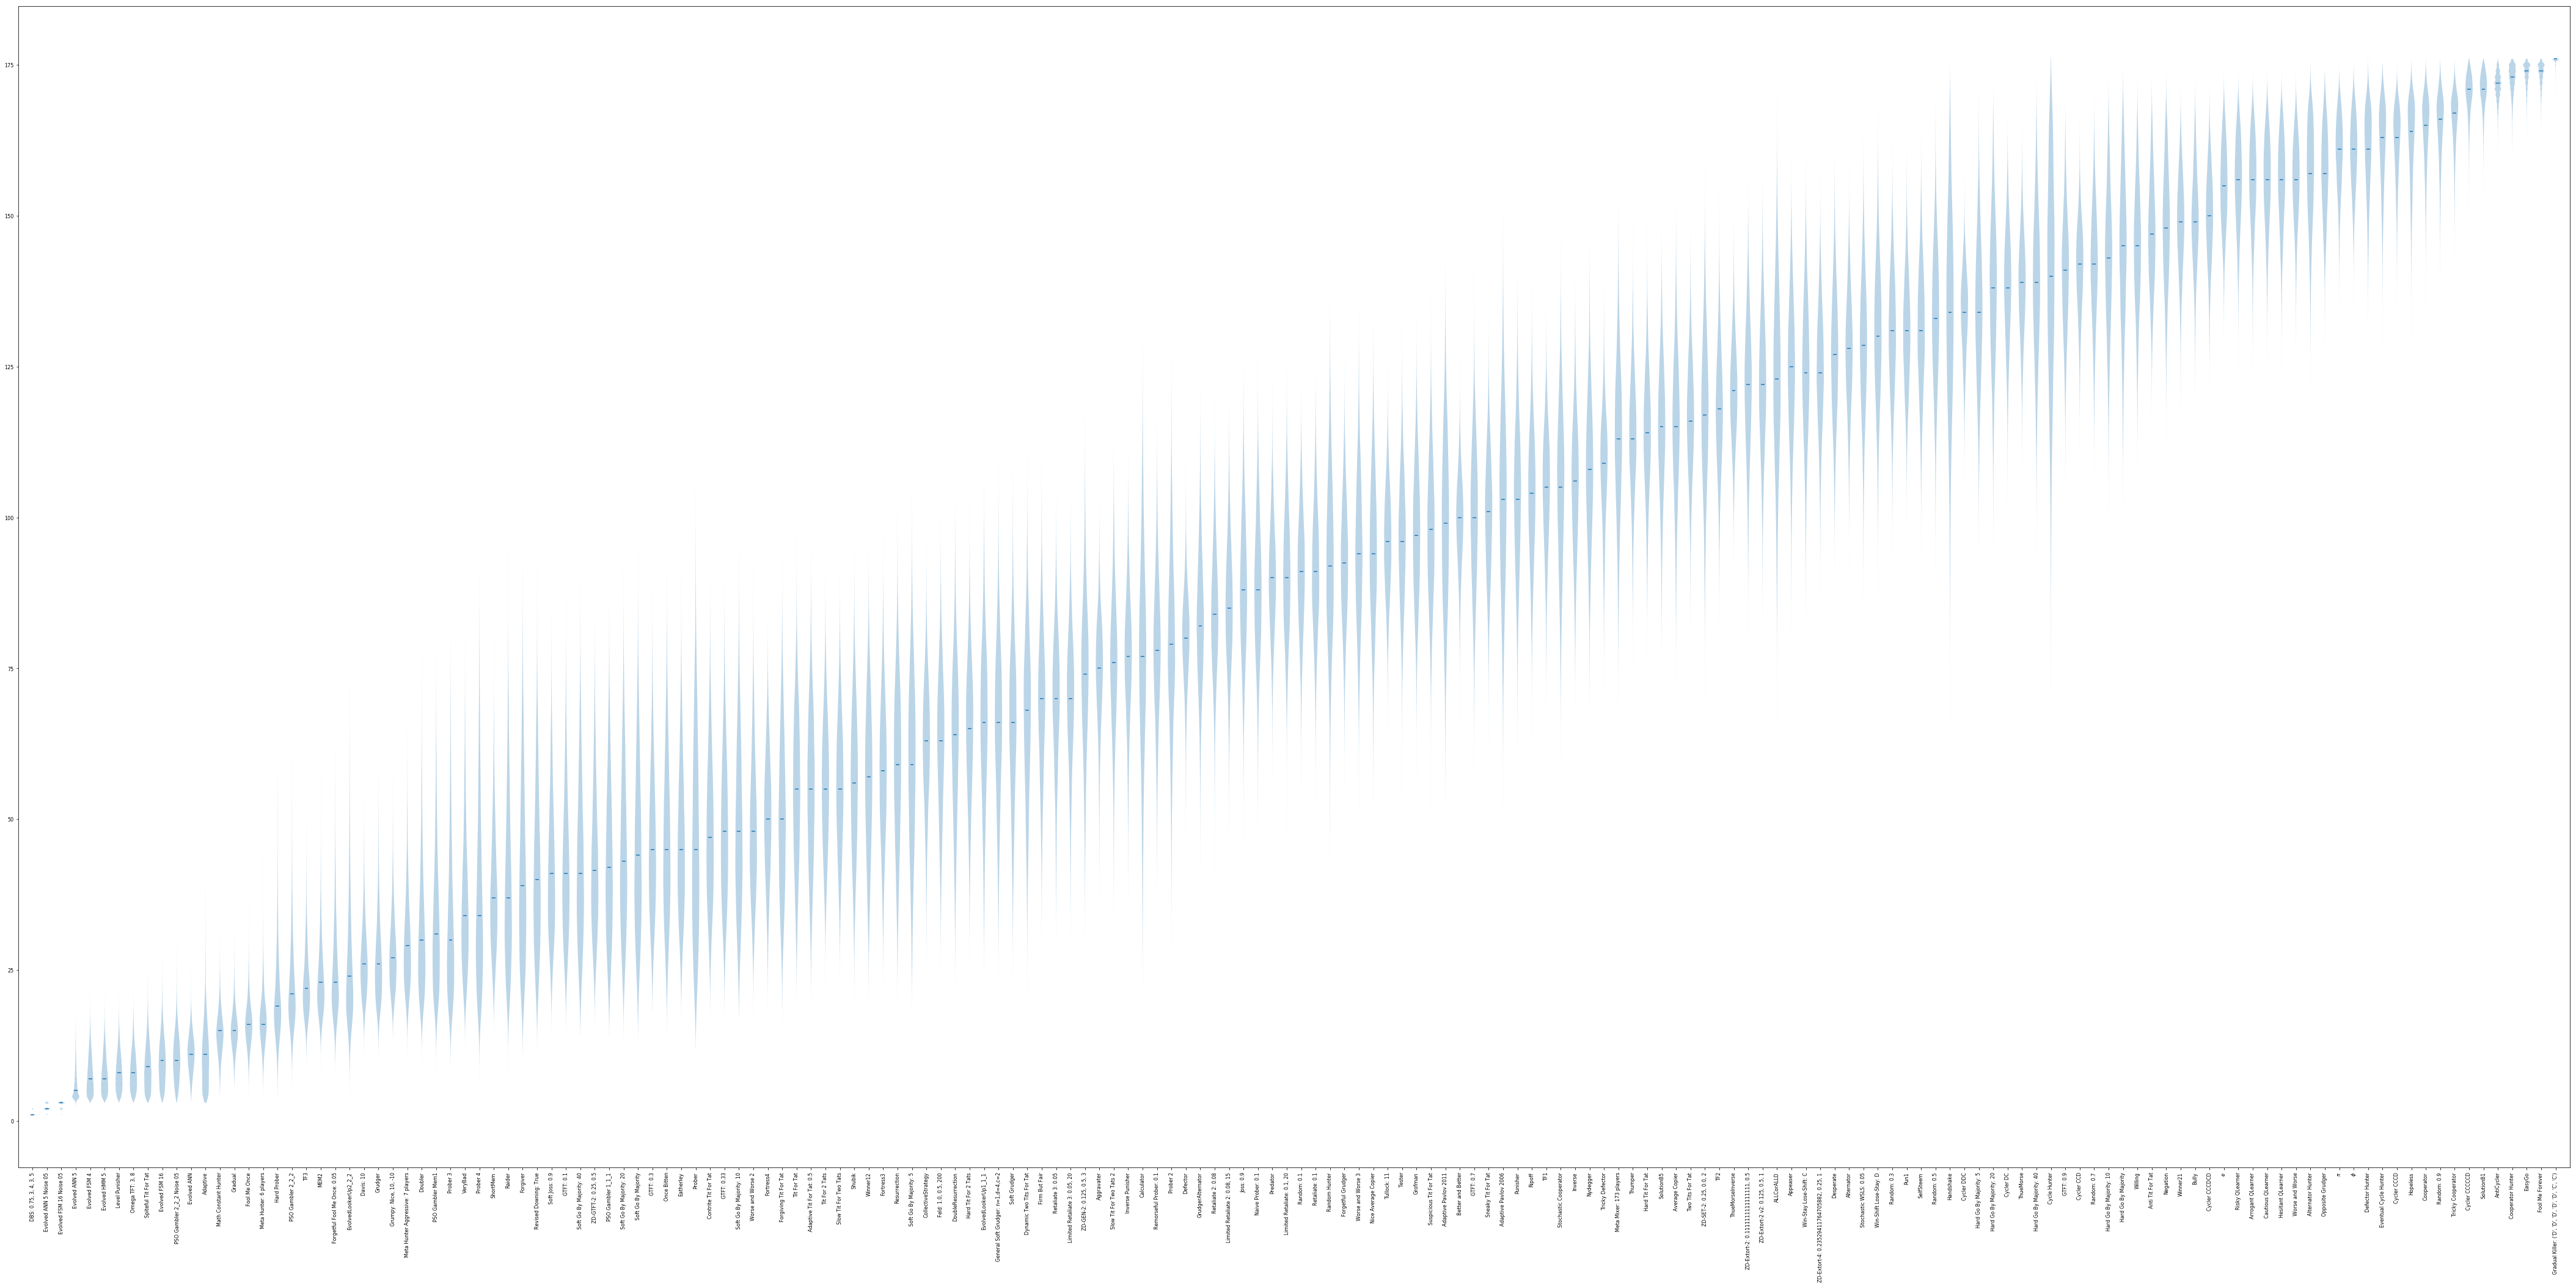

In [58]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/noisy_ranks_boxplots.pdf")

## Payoff matrix

In [59]:
payoff_matrix = read_payoff_matrix(files=noisy_files)
assert payoff_matrix.shape == (176, 176)

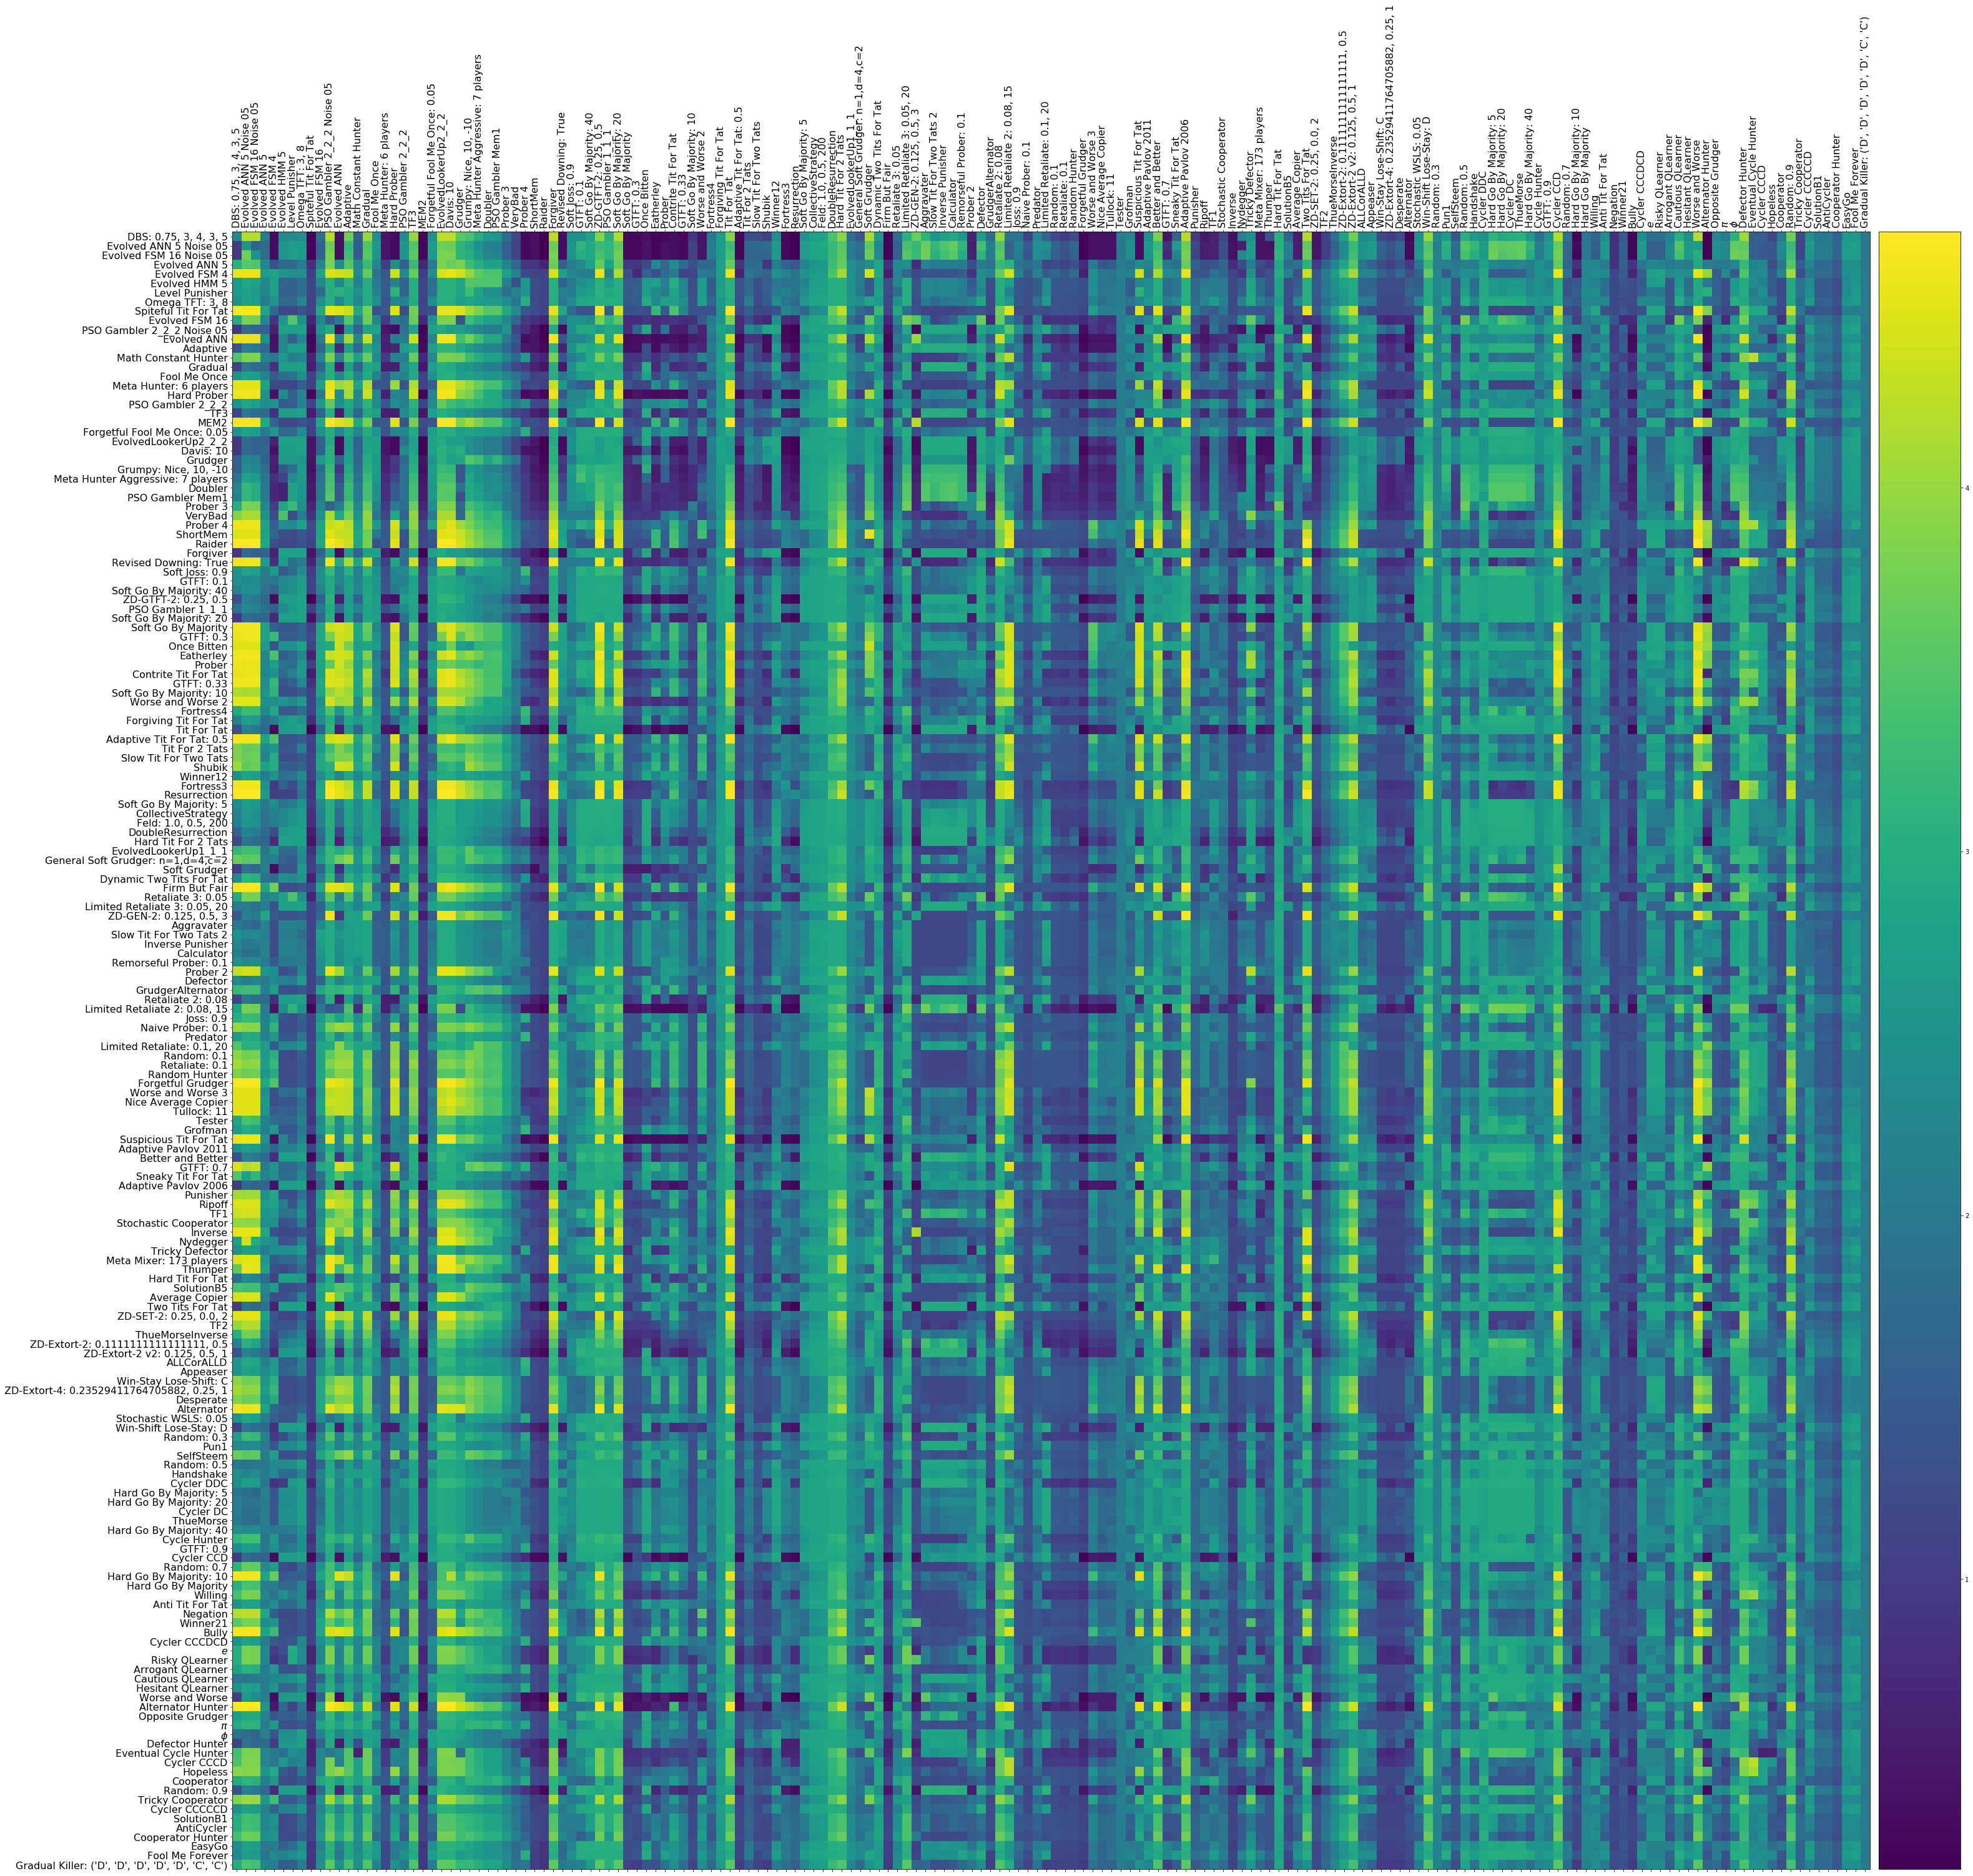

In [60]:
ranked_player_names = list(rank_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]
payoff_heatmap(payoff_matrix, ranked_player_names, "../assets/noisy_scores_heatmap.pdf")

## Wins

In [61]:
wins = read_wins(files=noisy_files)

In [62]:
win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min     5%    25%    50%  \
DBS: 0.75, 3, 4, 3, 5       102.537000  3.701109   87   97.0  100.0  102.0   
Evolved ANN 5 Noise 05       75.057600  4.221217   59   68.0   72.0   75.0   
Evolved FSM 16 Noise 05      88.735600  3.862834   75   82.0   86.0   89.0   
Evolved ANN 5               137.839467  4.396747  118  131.0  135.0  138.0   
Evolved FSM 4                74.211867  2.694685   64   70.0   72.0   74.0   
Evolved HMM 5                88.228867  2.773025   78   84.0   86.0   88.0   
Level Punisher               94.234867  4.726069   77   86.0   91.0   94.0   
Omega TFT: 3, 8             131.690067  4.304669  112  125.0  129.0  132.0   
Spiteful Tit For Tat        155.079333  3.319343  142  150.0  153.0  155.0   
Evolved FSM 16              103.295600  3.641580   89   97.0  101.0  103.0   
PSO Gambler 2_2_2 Noise 05   90.539667  4.010440   76   84.0   88.0   90.0   
Adaptive                    101.890800  4.915494   85   94.0   99.0  102.0   
Evolved ANN                 138.509667  3.391520  125  133.0  136.0  139.0   
Math Constant Hunter         92.975533  3.301665   79   88.0   91.0   93.0   
Gradual                     101.874733  2.846375   92   97.0  100.0  102.0   

                              75%    95%  max  
DBS: 0.75, 3, 4, 3, 5       105.0  109.0  118  
Evolved ANN 5 Noise 05       78.0   82.0   93  
Evolved FSM 16 Noise 05      91.0   95.0  104  
Evolved ANN 5               141.0  145.0  154  
Evolved FSM 4                76.0   79.0   84  
Evolved HMM 5                90.0   93.0   99  
Level Punisher               97.0  102.0  112  
Omega TFT: 3, 8             135.0  139.0  148  
Spiteful Tit For Tat        157.0  160.0  167  
Evolved FSM 16              106.0  109.0  118  
PSO Gambler 2_2_2 Noise 05   93.0   97.0  107  
Adaptive                    105.0  110.0  122  
Evolved ANN                 141.0  144.0  152  
Math Constant Hunter         95.0   98.0  107  
Gradual                     104.0  107.0  114

In [63]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

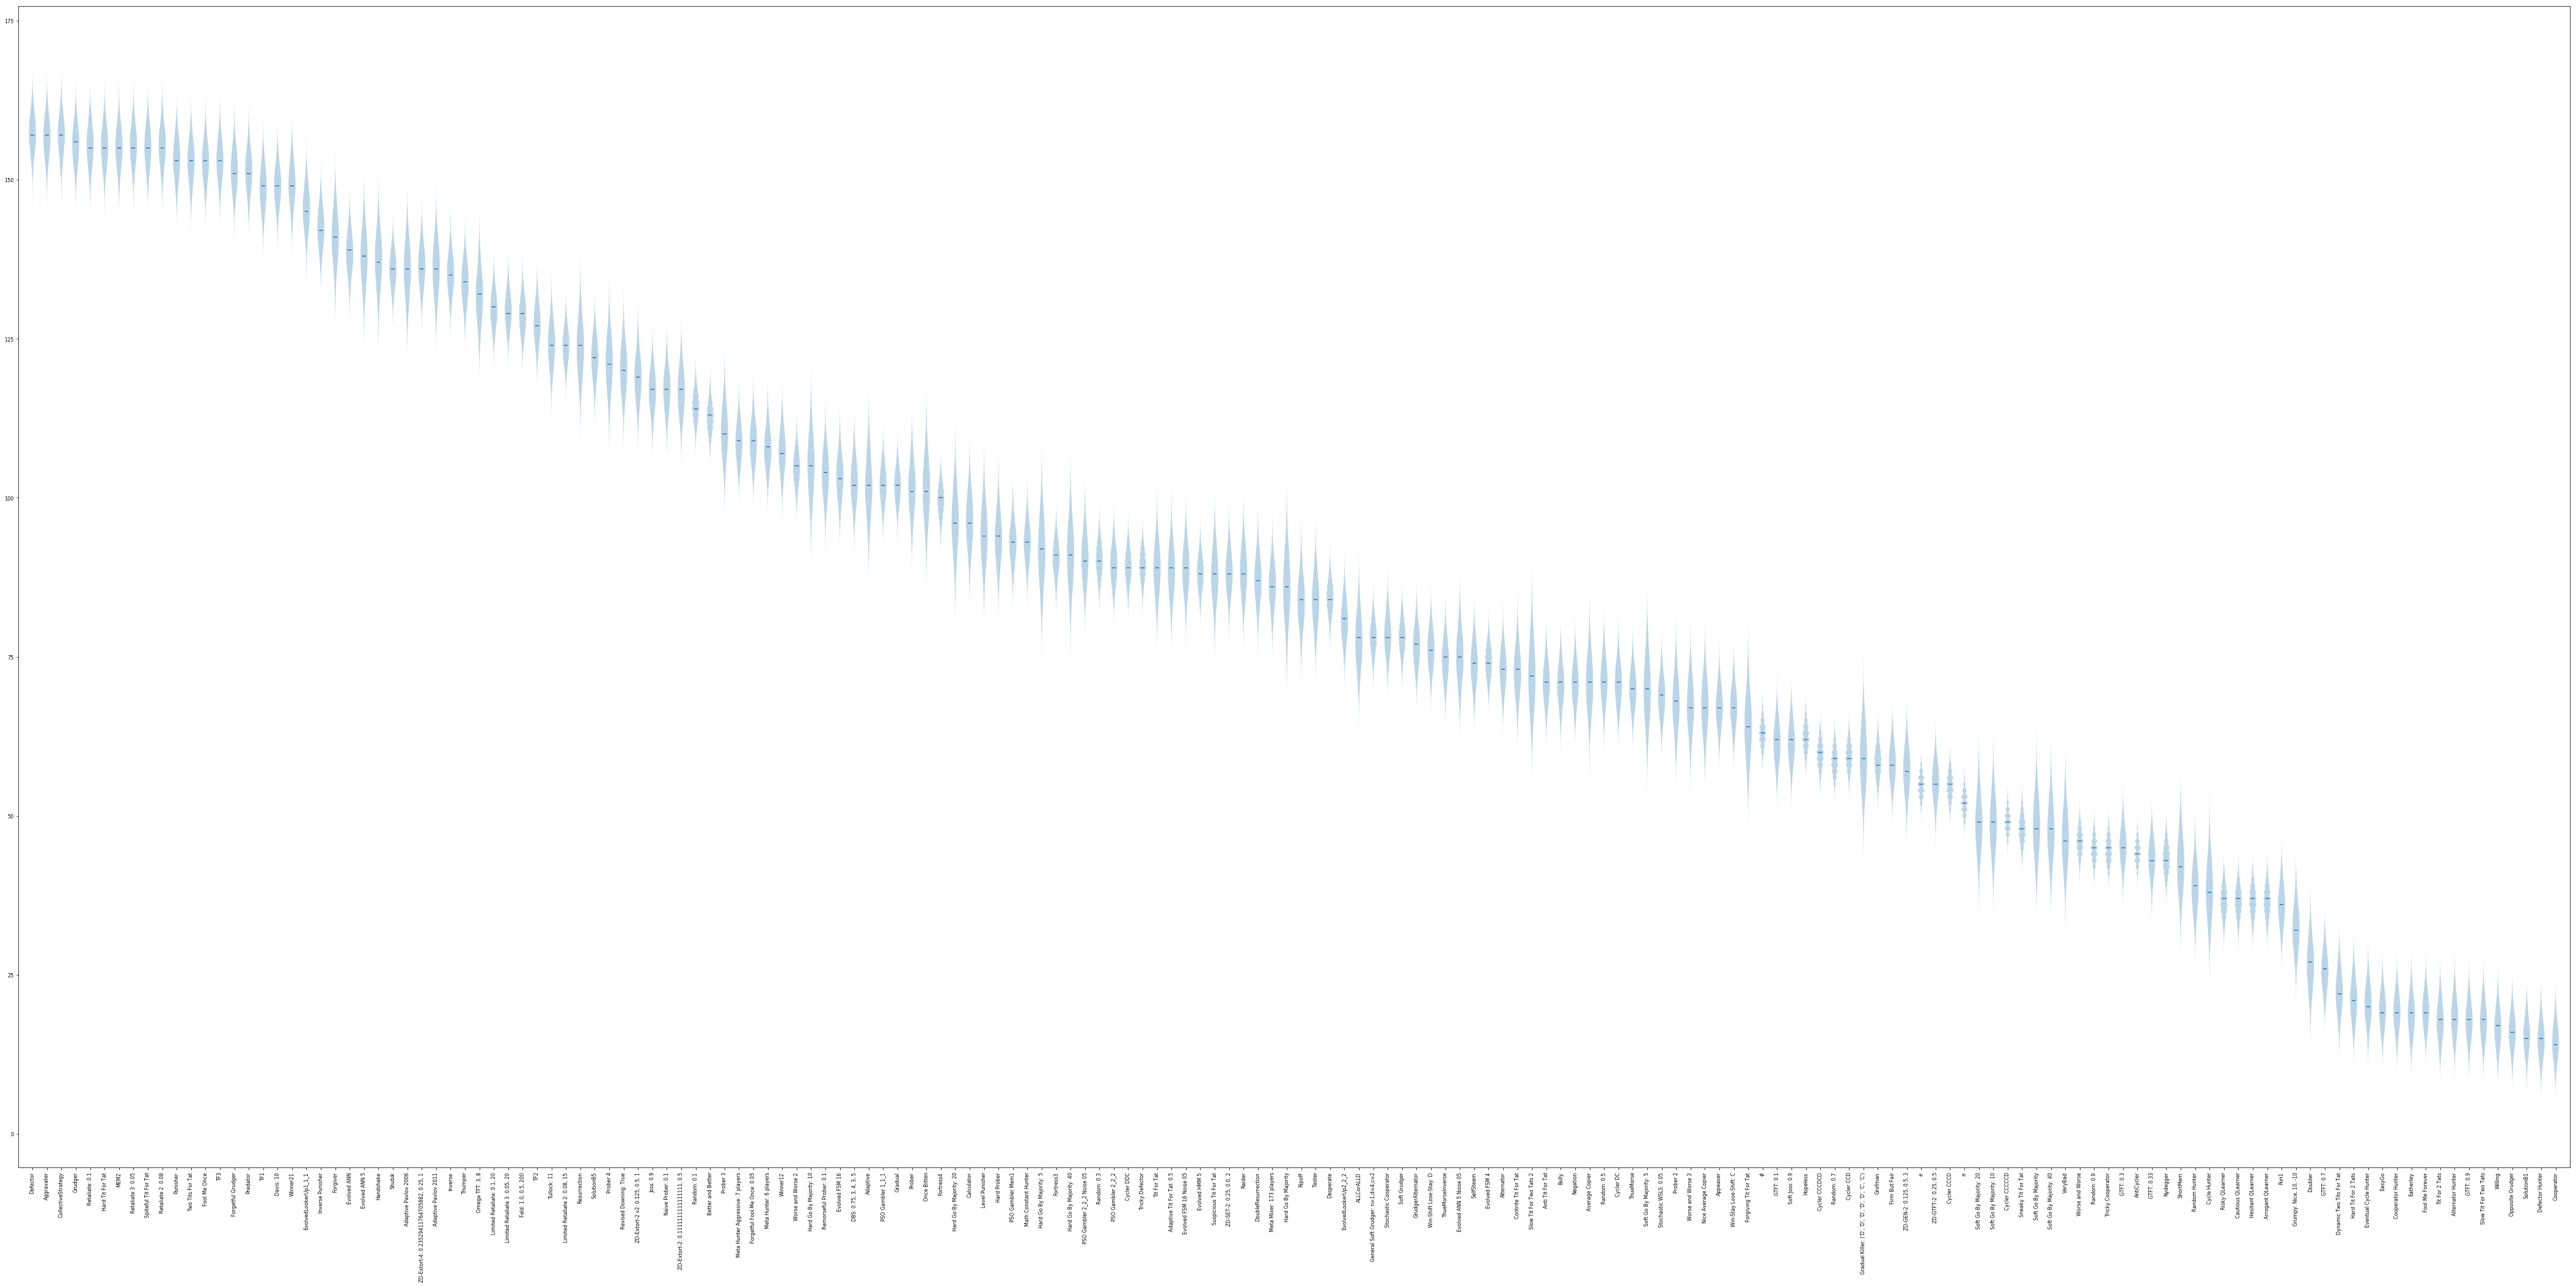

In [64]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/noisy_wins_boxplots.pdf")